In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import scipy.signal as signal
from mpl_toolkits.mplot3d import Axes3D
import time

In [2]:
''' taylorF2 model'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return m1,m2
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
def F_cross(theta,psi,phi):
    return 0.5*(1+np.power(np.cos(theta),2))*np.cos(2*phi)*np.sin(2*psi)-np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)
def F_plus(theta,psi,phi):
    return -0.5*(1+np.power(np.cos(theta),2))*np.cos(2.0*phi)*np.cos(2*psi)-np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
def D_eff(D,theta,psi,phi,iota):
    return D/(np.sqrt(np.power(F_cross(theta,psi,phi),2.0)*np.power(np.cos(iota),2.0)+np.power(F_plus(theta,psi,phi),2)*0.25*(1+np.power(np.cos(iota),2))))
def Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c,v_lso=1/np.sqrt(6.0)):
    Mcal=m_c/np.power(smr,0.6)
    v=np.pow er(sciconsts.pi*Mcal*f,1/3.0)
    return 2*sciconsts.pi*f*t_c-phi_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v/v_lso))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c):
    return np.power(m_c,5.0/6.0)/D_eff(D,theta,psi,phi,iota)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi(f,m_c,smr,D,theta,psi,phi,iota,t_c,phi_c))
def Psi2(f,m_c,smr,t_c):
    Mcal2=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal2*f,1/3.0)
    return 2*sciconsts.c*f*t_c-sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v*np.sqrt(6.0)))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h_mod(f,m_c,smr,t_c):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi2(f,m_c,smr,t_c))*1e-48
def Psi3(f,m_c,smr):
    Mcal2=m_c/np.power(smr,0.6)
    v=np.power(sciconsts.pi*Mcal2*f,1/3.0)
    return -sciconsts.pi*0.25+3.0/(128.0*smr*np.power(v,5.0))*(1+20/9.0*(743/336.0+11/4.0*smr)*np.power(v,2.0)-16.0*sciconsts.pi*np.power(v,3.0)+10.0*(3058673.0/1016064.0+5429/1008.0*smr+617.0/144.0*np.power(smr,2.0))*np.power(v,4.0)+sciconsts.pi*(38645.0/756.0-65/9.0*smr)*(1+3*np.log(v*np.sqrt(6.0)))*np.power(v,5.0)+(11583231236531.0/4694215680.0+640.0/3.0*np.power(sciconsts.pi,2)-6848.0/21.0*0.57721566490153286060651209-6848/21.0*np.log(4.0*v)+(-15737765635.0/3048192+2255.0*np.power(sciconsts.pi,2.0)/12.0)*smr+76055.0/1728*np.power(smr,2.0)-127825/1296*np.power(smr,3.0))*np.power(v,6.0)+sciconsts.pi*(77096675.0/254016.0+378515.0/1512.0*smr-74045.0/756.0*np.power(smr,2.0))*np.power(v,7.0))
def h_mod2(f,m_c,smr):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1.0j*Psi3(f,m_c,smr))*1e-48
'''cutler vac Fmode'''
def h_modc(f,m_c,t_c):
    return np.power(m_c,5.0/6.0)*np.power(f,-7.0/6.0)*np.exp(1j*(2*sciconsts.pi*t_c*f-0.25*sciconsts.pi+0.75*np.power(8*sciconsts.pi*f*m_c),-5.0/3.0))
def t_ccal(m_c,a_0):
    return np.power(a_0,4.0)/4.0/k_1cal(m_1,m_2)
def freq_tc(t,m_c,m_1,m_2):
    return 1.0/sciconsts.pi*np.sqrt(sciconsts.G*())
'''my Fmodel(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acal(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_t(t,m_1,m_2,t_gas,t_0):
    a_ft=acal(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def t_f(f,m_1,m_2,t_gas,t_0):
    lab0=sciconsts.pi/np.power(sciconsts.G*(m_1+m_2),0.5)
    k2=k_1cal(m_1,m_2)
    return t_0-t_gas/4.0*np.log(k2+1.0/t_gas*np.power(lab0*f,-8.0/3.0))
def phi_t(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_t(x,m_1,m_2,t_gas,t_0),0,t)[0]
def dfdt(f,m_1,m_2,t_gas,t_0):
    lab=sciconsts.pi/np.power(sciconsts.G*(m_1+m_2),0.5)
    k4=k_1cal(m_1,m_2)
    return 1.5/lab*np.power(lab*f,11.0/3.0)*(k4+np.power(lab*f,-8.0/3.0)/t_gas)
def h_fgas(f,m_1,m_2,t_gas,t_0):
    trev=t_f(f,m_1,m_2,t_gas,t_0)
    a3=acal(trev,k_1,t_gas,t_0)
    return 0.5*m_1*m_2/a3/np.sqrt(dfdt(f,m_1,m_2,t_gas,t_0))*np.exp(1.0j*(2*sciconsts.pi*trev-phi_t(trev,m_1,m_2,t_gas,t_0)-0.25*sciconsts.pi))*1e-79
def h_fgas_rev(f,m_1,m_2,t_gas,t_0):
    trev=t_f(f,m_1,m_2,t_gas,t_0)
    a3=acal(trev,k_1cal(m_1,m_2),t_gas,t_0)
    return 0.5*m_1*m_2/a3/np.sqrt(dfdt(f,m_1,m_2,t_gas,t_0))*np.exp(-1.0j*(2*sciconsts.pi*trev-phi_t(trev,m_1,m_2,t_gas,t_0)-0.25*sciconsts.pi))*1e-79


def h_fgas_q(f,m_1,m_2,t_gas,t_0,phitinter):
    trev=t_f(f,m_1,m_2,t_gas,t_0)
    a3=acal(trev,k_1cal(m_1,m_2),t_gas,t_0)
    return 0.5*m_1*m_2/a3/np.sqrt(dfdt(f,m_1,m_2,t_gas,t_0))*np.exp(-1.0j*(2*sciconsts.pi*trev-phitinter(trev)-0.25*sciconsts.pi))*1e-79
def h_fgas_revq(f,m_1,m_2,t_gas,t_0,phitinter):
    trev=t_f(f,m_1,m_2,t_gas,t_0)
    a3=acal(trev,k_1cal(m_1,m_2),t_gas,t_0)
    return 0.5*m_1*m_2/a3/np.sqrt(dfdt(f,m_1,m_2,t_gas,t_0))*np.exp(-1.0j*(2*sciconsts.pi*trev-phitinter(trev)-0.25*sciconsts.pi))*1e-79
'''my Tmodel(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,k_1,t_gas,t_0,phi):
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)/1e60

def freq_ana(f,N):
    jugg=np.where(f>=f.max()*0.95)
    ni=jugg[0][0]
    nf=jugg[0][jugg[0].size-1]
    dfi=(0.01-0.0001)/N
    fi=0.0001+dfi*ni
    ff=0.0001+dfi*nf
    return (fi,f[ni]),(ff,f[nf])


'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)

In [3]:
m_sun=1.9891e30
m_1=10*m_sun
m_2=10*m_sun
t_gas=1000.0*365*24*3600
a_0=3.0e8

In [4]:
k_1=k_1cal(m_1,m_2)
t_0=t_0cal(m_1,m_2,t_gas,a_0)
years=365*24*3600.0
N=100000
t_scale=4*years
r=10*1e6*3.261*sciconsts.light_year#distance=10MPC
t=np.linspace(0,4.1*years,num=N)
fi=freq_t(0,m_1,m_2,t_gas,t_0)
ff=freq_t(4*years,m_1,m_2,t_gas,t_0)

In [5]:
i=0
workphi=np.zeros(N)
while i<N:
    workphi[i]=phi_t(t[i],m_1,m_2,t_gas,t_0)
    i=i+1
phiq=sci_interpolate.interp1d(t,workphi,kind='cubic')

In [96]:
A=np.sqrt(sci_integrate.quad(lambda x:4*np.power(abs(h_fgas(x,m_1,m_2,t_gas,t_0)),2.0)/S_n_lisa(x),fi,ff))
#B=sci_integrate.quad(lambda x:np.power(h_mod(),2.0)/S_n_lisa(f),0.0001,0.1)
A

array([  1.08381520e-01,   1.14198487e-08])

In [155]:
nd=42
m_1m=nd*m_sun
m_2m=nd*m_sun
#mcm=chirp_mass(m_1m,m_2m)
mcm=36.56*m_sun
#smrm=sym_mass_ratio(m_1m,m_2m)
smrm=0.3
B=np.sqrt(sci_integrate.quad(lambda x:4*np.power(abs(h_mod2(x,mcm,smrm)),2.0)/S_n_lisa(x),fi,ff))
B,A[0]*B[0]

(array([  1.95537779e-01,   2.06032528e-08]), 0.021192681628507029)

In [160]:
'''
i=0
work5=np.zeros(N2,dtype='complex128')
while i<N2:
    a=h_fgas_revq(fm2[i],m_1,m_2,t_gas,t_0,phiq)
    b=h_mod2(fm2[i],mcm,smrm)1
    c=1.0/S_n_lisa(fm2[i])
    work5[i]=a*b*c
    i=i+1'''
t1=time.clock()
N2=1000000
fm2=np.linspace(fi,ff,N2)
df=(ff-fi)
c=1.0/S_n_lisa((fi+ff)/2.0)
work5=h_fgas_revq(fm2,m_1,m_2,t_gas,t_0,phiq)*h_mod2(fm2,mcm,smrm)
yfftm2=fft.ifft(work5)
AB=abs(yfftm2).max()*c*2.0*df
t2=time.clock()
(AB,AB/A[0]/B[0]),t2-t1,np.exp(AB)

((4.0039883845383303e-05, 0.0018893259733362025),
 1.1886749999999893,
 1.0000400406854522)

In [158]:
mcm/m_sun

36.56

#### ff-fi

In [263]:
smrm

0.25

In [103]:
N3=10000
f=np.linspace(0.0001,0.1,N3)
#f_t=freq_t(t,m_1,m_2,t_gas,t_0)
#work4=freq_t(t,m_1,m_2,t_gas,t_0)
work1=np.zeros(N3)
work2=np.zeros(N3)
work3=np.zeros(N3)
#work2=abs(h_mod(f,chirp_mass(10*m_sun,10*m_sun),0.25,10000000*years))
i=0
mig=40*m_sun
t_02=t_0cal(mig,mig,t_gas,a_0)
while i<N3:
    #work1[i]=phi_t(t[i],m_1,m_2,t_gas,t_0)%(2*sciconsts.pi)
    #print phi_t(t[i],m_1,m_2,t_gas,t_0)
    #work2[i]=phi_h_f_gas(f[i],m_1,m_2,t_gas,t_0)%(2*sciconsts.pi)
    #work3[i]=abs(h_f(f[i],m_1,m_2,t_gas,t_0))
    work1[i]=abs(h_fgas(f[i],mig,mig,t_gas,t_02))
    i=i+1

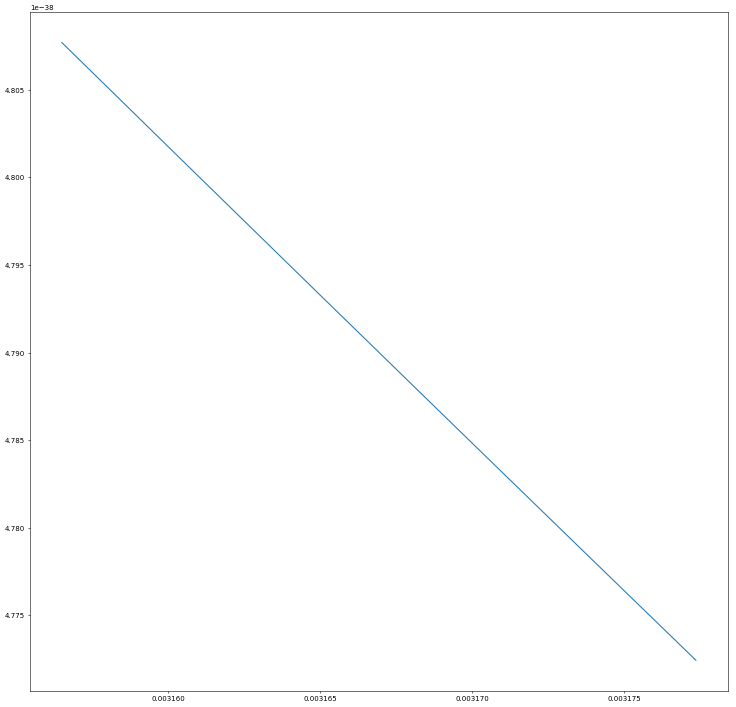

In [25]:
fig1=plt.figure(figsize=(18,18),dpi=50)
plt.plot(fm2,abs(work5))
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0.00150,0.0022)
plt.show()

In [49]:
5%3.14

1.8599999999999999

In [117]:
cm/m_sun

43.527528164806036

In [6]:
m_1=10*m_sun
m_2=10*m_sun
A=np.sqrt(sci_integrate.quad(lambda x:4*np.power(abs(h_fgas(x,m_1,m_2,t_gas,t_0cal(m_1,m_2,t_gas,a_0))),2.0)/S_n_lisa(x),fi,ff))
#B=sci_integrate.quad(lambda x:np.power(h_mod(),2.0)/S_n_lisa(f),0.0001,0.1)
A

array([  1.08381520e-01,   1.14198487e-08])

In [132]:
m_1=12.0*m_sun
m_2=12.0*m_sun
cm=chirp_mass(m_1,m_2)
B=np.sqrt(sci_integrate.quad(lambda x:4*np.power(abs(h_mod2(x,cm,0.25)),2.0)/S_n_lisa(x),fi,ff))
B,A[0]*B[0]

(array([  6.88448663e-02,   7.25398537e-09]), 0.0074615112325288196)

In [145]:
'''    a=h_fgas(fm2[i],10*m_sun,10*m_sun,t_gas,t_0cal(10*m_sun,10*m_sun,t_gas,a_0))
    b=h_mod2(fm2[i],cm,0.25)
    c=1.0/S_n_lisa(fm2[i])
    work5[i]=(a.real*b.real+a.imag*b.imag)*c+(a.real*b.imag-a.imag*b.real)*c*1j
    work5[2*N2-i-1]=work5[i]
    i=i+1'''
m_1=10.0*m_sun
m_2=10.0*m_sun
cm=chirp_mass(m_1,m_2)
t1=time.clock()
N2=110000
fm2=np.linspace(fi,ff,N2)
i=0
work5=np.zeros(2*N2,dtype='complex128')
B=np.sqrt(sci_integrate.quad(lambda x:4*np.power(abs(h_mod2(x,cm,0.25)),2.0)/S_n_lisa(x),fi,ff))
while i<N2:
    a=h_fgas_rev(fm2[i],10*m_sun,10*m_sun,t_gas,t_0cal(10*m_sun,10*m_sun,t_gas,a_0))
    b=h_mod2(fm2[i],cm,0.25)
    c=1.0/S_n_lisa(fm2[i])
    work5[i]=a*b*c
    work5[2*N2-i-1]=work5[i]
    i=i+1
yfftm2=fft.ifft(work5)
AB=abs(yfftm2).max()*20
t2=time.clock()
AB/A[0]/B[0],t2-t1


(1689.0603863089971, 47.05998899999986)

In [159]:
h_f(x,m_1,m_2,t_gas,t_0).real*h_mod2(x,cm,0.25).real+h_f(x,m_1,m_2,t_gas,t_0).imag*h_mod2(x,cm,0.25).imag

In [93]:
t1=time.clock()
a3=sci_integrate.quad(lambda x:4*(h_fgas_rev(x,10*m_sun,10*m_sun,t_gas,t_0cal(10*m_sun,10*m_sun,t_gas,a_0))*h_mod2(x,chirp_mass(42.5*m_sun,42.5*m_sun),0.25)).real/S_n_lisa(x),fi,ff)
t2=time.clock()
a3,t2-t1

((-0.0024813774191931037, 0.006111975504961186), 0.9335960000000796)

In [152]:
ym2=np.zeros(N2,dtype='complex128')

In [153]:
ym2

array([ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j])

In [154]:
ym2[1].real

0.0

In [250]:
df

9.900000000000001e-08

In [26]:
help(np.concatenate)

Help on built-in function concatenate in module numpy.core.multiarray:

concatenate(...)
    concatenate((a1, a2, ...), axis=0)
    
    Join a sequence of arrays along an existing axis.
    
    Parameters
    ----------
    a1, a2, ... : sequence of array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int, optional
        The axis along which the arrays will be joined.  Default is 0.
    
    Returns
    -------
    res : ndarray
        The concatenated array.
    
    See Also
    --------
    ma.concatenate : Concatenate function that preserves input masks.
    array_split : Split an array into multiple sub-arrays of equal or
                  near-equal size.
    split : Split array into a list of multiple sub-arrays of equal size.
    hsplit : Split array into multiple sub-arrays horizontally (column wise)
    vsplit : Split array into multiple sub-arrays vertically (row wise)
    dsp

In [186]:
abs(yfftm2).max()

2.3510044710411003e-39

In [67]:
sci_integrate.quad(lambda x:4*(h_fgas(x,m_1,m_2,t_gas,t_0).real*h_mod(x,cm,0.25,69689710683.915726).real+h_fgas(x,m_1,m_2,t_gas,t_0).imag*h_mod(x,cm,0.25,69689710683.915726).imag)/S_n_lisa(x),fi,ff)

/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


(-0.00019051502340170068, 0.0007080626112248613)

In [278]:
t02cal(20*m_sun,20*m_sun,484618279.8606534)

69689710683.915726

In [279]:
69689710683/years

2209.8462291666665

In [40]:
h_fgas(0.00001,m_1,m_2,t_gas,t_0)

/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in power


(nan+nan*j)

In [36]:
dfdt(0.000001,m_1,m_2,t_gas,t_0)

4.7564687999003842e-17

In [42]:
acal(t_f(0.0001,m_1,m_2,t_gas,t_0),k_1cal(m_1,m_2),t_gas,t_0)

4834399341.1512508

In [61]:
t_f(0.0032,m_1,m_2,t_gas,t_0)

261990549.93048096

In [160]:
mif=10*m_sun
fi=freq_t(0,mif,mif,t_gas,t_0cal(mif,mif,t_gas,a_0))
ff=freq_t(4*years,mif,mif,t_gas,t_0cal(mif,mif,t_gas,a_0))

4.0000000000019353

13498.678131975688

In [60]:
a_0

300000000.0

In [61]:
t_03

461060423199.53192

In [125]:
1/3.0

0.3333333333333333

In [136]:
t_0cal(10*m_sun,10*m_sun,t_gas,a_0)-np.log(k_1cal(10*m_sun,10*m_sun))*t_gas/4.0

19176084505.248596

In [137]:
19176084505/years

608.0696507166413

In [189]:
f=np.linspace(fi,ff,10000)

In [190]:
S_n_lisa(f)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [267]:
a=np.array((1,2))
a

array([1, 2])

In [270]:
b=np.array((1,2))
b

array([1, 2])

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [284]:
a=np.linspace(0,10,11)
a

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [286]:
b=np.linspace(11,20,10)
b

array([ 11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.])

In [20]:
zero1=np.zeros(10000)
zero2=np.zeros(100000)
a=list(zero1)
b=list(zero2)
a.append(b)
a=np.array(a)

ValueError: setting an array element with a sequence.

In [27]:
int((fi-0.0001)/df)

14661327

In [34]:
N2=10000
df=(ff-fi)/N2
N1=int((fi-0.0001)/df)
N3=int((0.01-ff)/df)
N1,N3

(1466132, 3272653)